# Setup

Importing libraries, reaading the dataframe from the excel file, setting the seed for reproducibility and setting <code>ignore warnings</code>.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns

df = pd.read_excel('Needs.xls')

seed = 69

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

The first column (<code>ID</code>) is deleted, since it is useless for classification purposes.

In [2]:
df.drop(labels='ID', axis=1, inplace=True)

The dataframe is shuffled and split into samples (<code>x_df</code>) and targets (<code>y_inc_df</code> and <code>y_acc_df</code>). The target dataframes are two since two different classifiers will be used to predict <code>income investment propensity</code> and <code>accumulation investment propensity</code>.

In [3]:
df = df.sample(frac = 1, random_state = seed)

x_df = df[['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth']]
y_inc_df = df['IncomeInvestment']
y_acc_df = df['AccumulationInvestment']

The dataframes are split into training and test sets (splits: $85\%$ training, $15\%$ test). All preprocessing parameters (e.g. $\mu$ and $\sigma$ for standardization) will be evaluated on the training set and applied to the test set to prevent the introduction of bias on the test set.

Hyperparameter optimization will be done using k-fold cross validation.

In [4]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_inc_train, y_inc_test = train_test_split(x_df, y_inc_df, test_size=0.15, random_state=seed)
x_train, x_test, y_acc_train, y_acc_test = train_test_split(x_df, y_acc_df, test_size=0.15, random_state=seed)

# Data Exploration

Feature distributions are plotted.

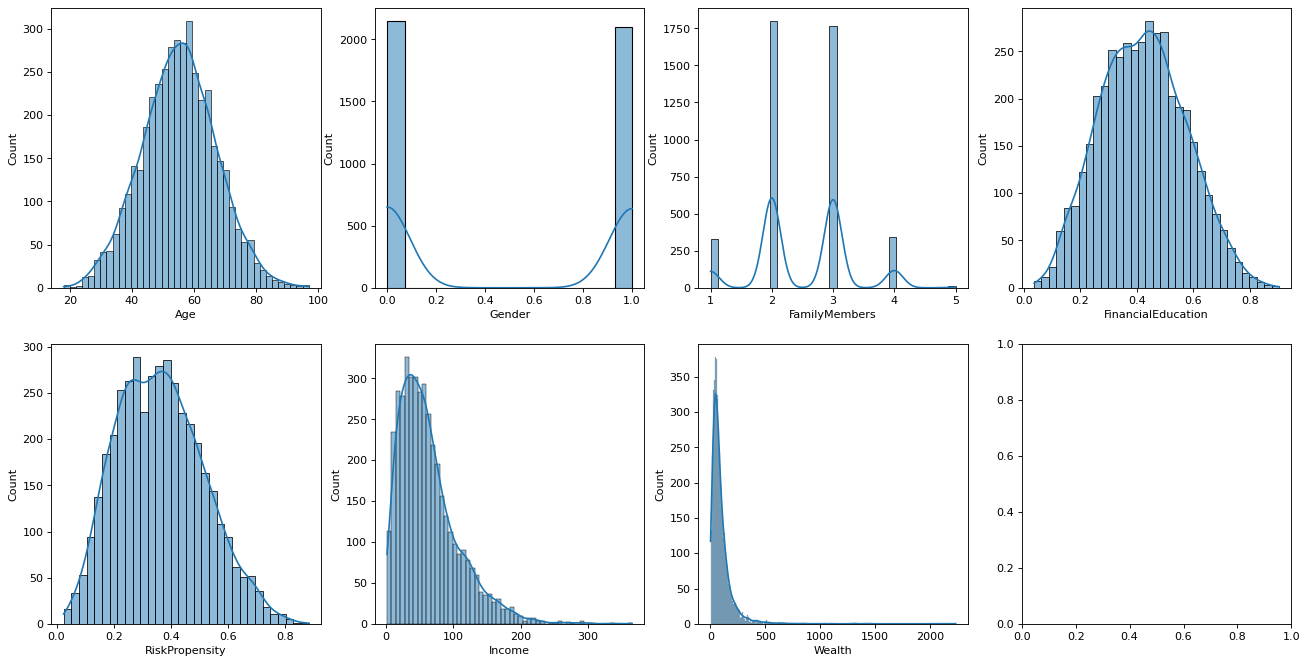

In [54]:
# defining the number of subplots per row and column
n_rows = 2
n_cols = 4

# creating the figure and the set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20,10), dpi=80)
features = x_train.columns

# initializing the row and column indexes
row = column = 0

# for each feature: select the correct axis, plot the feature distribution and update the indexes
for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_train, x=f, ax=ax, kde=True)

    column = column + 1
    if column % n_cols == 0:
        column = 0
        row = row + 1 

The scatterplots of each feature versus the other using the labels <code>IncomeInvestment</code> and <code>AccumulationInvestment</code> as grouping variables are plotted. This is done mainly to determine whether one or more features could be considered useless for classification purposes.

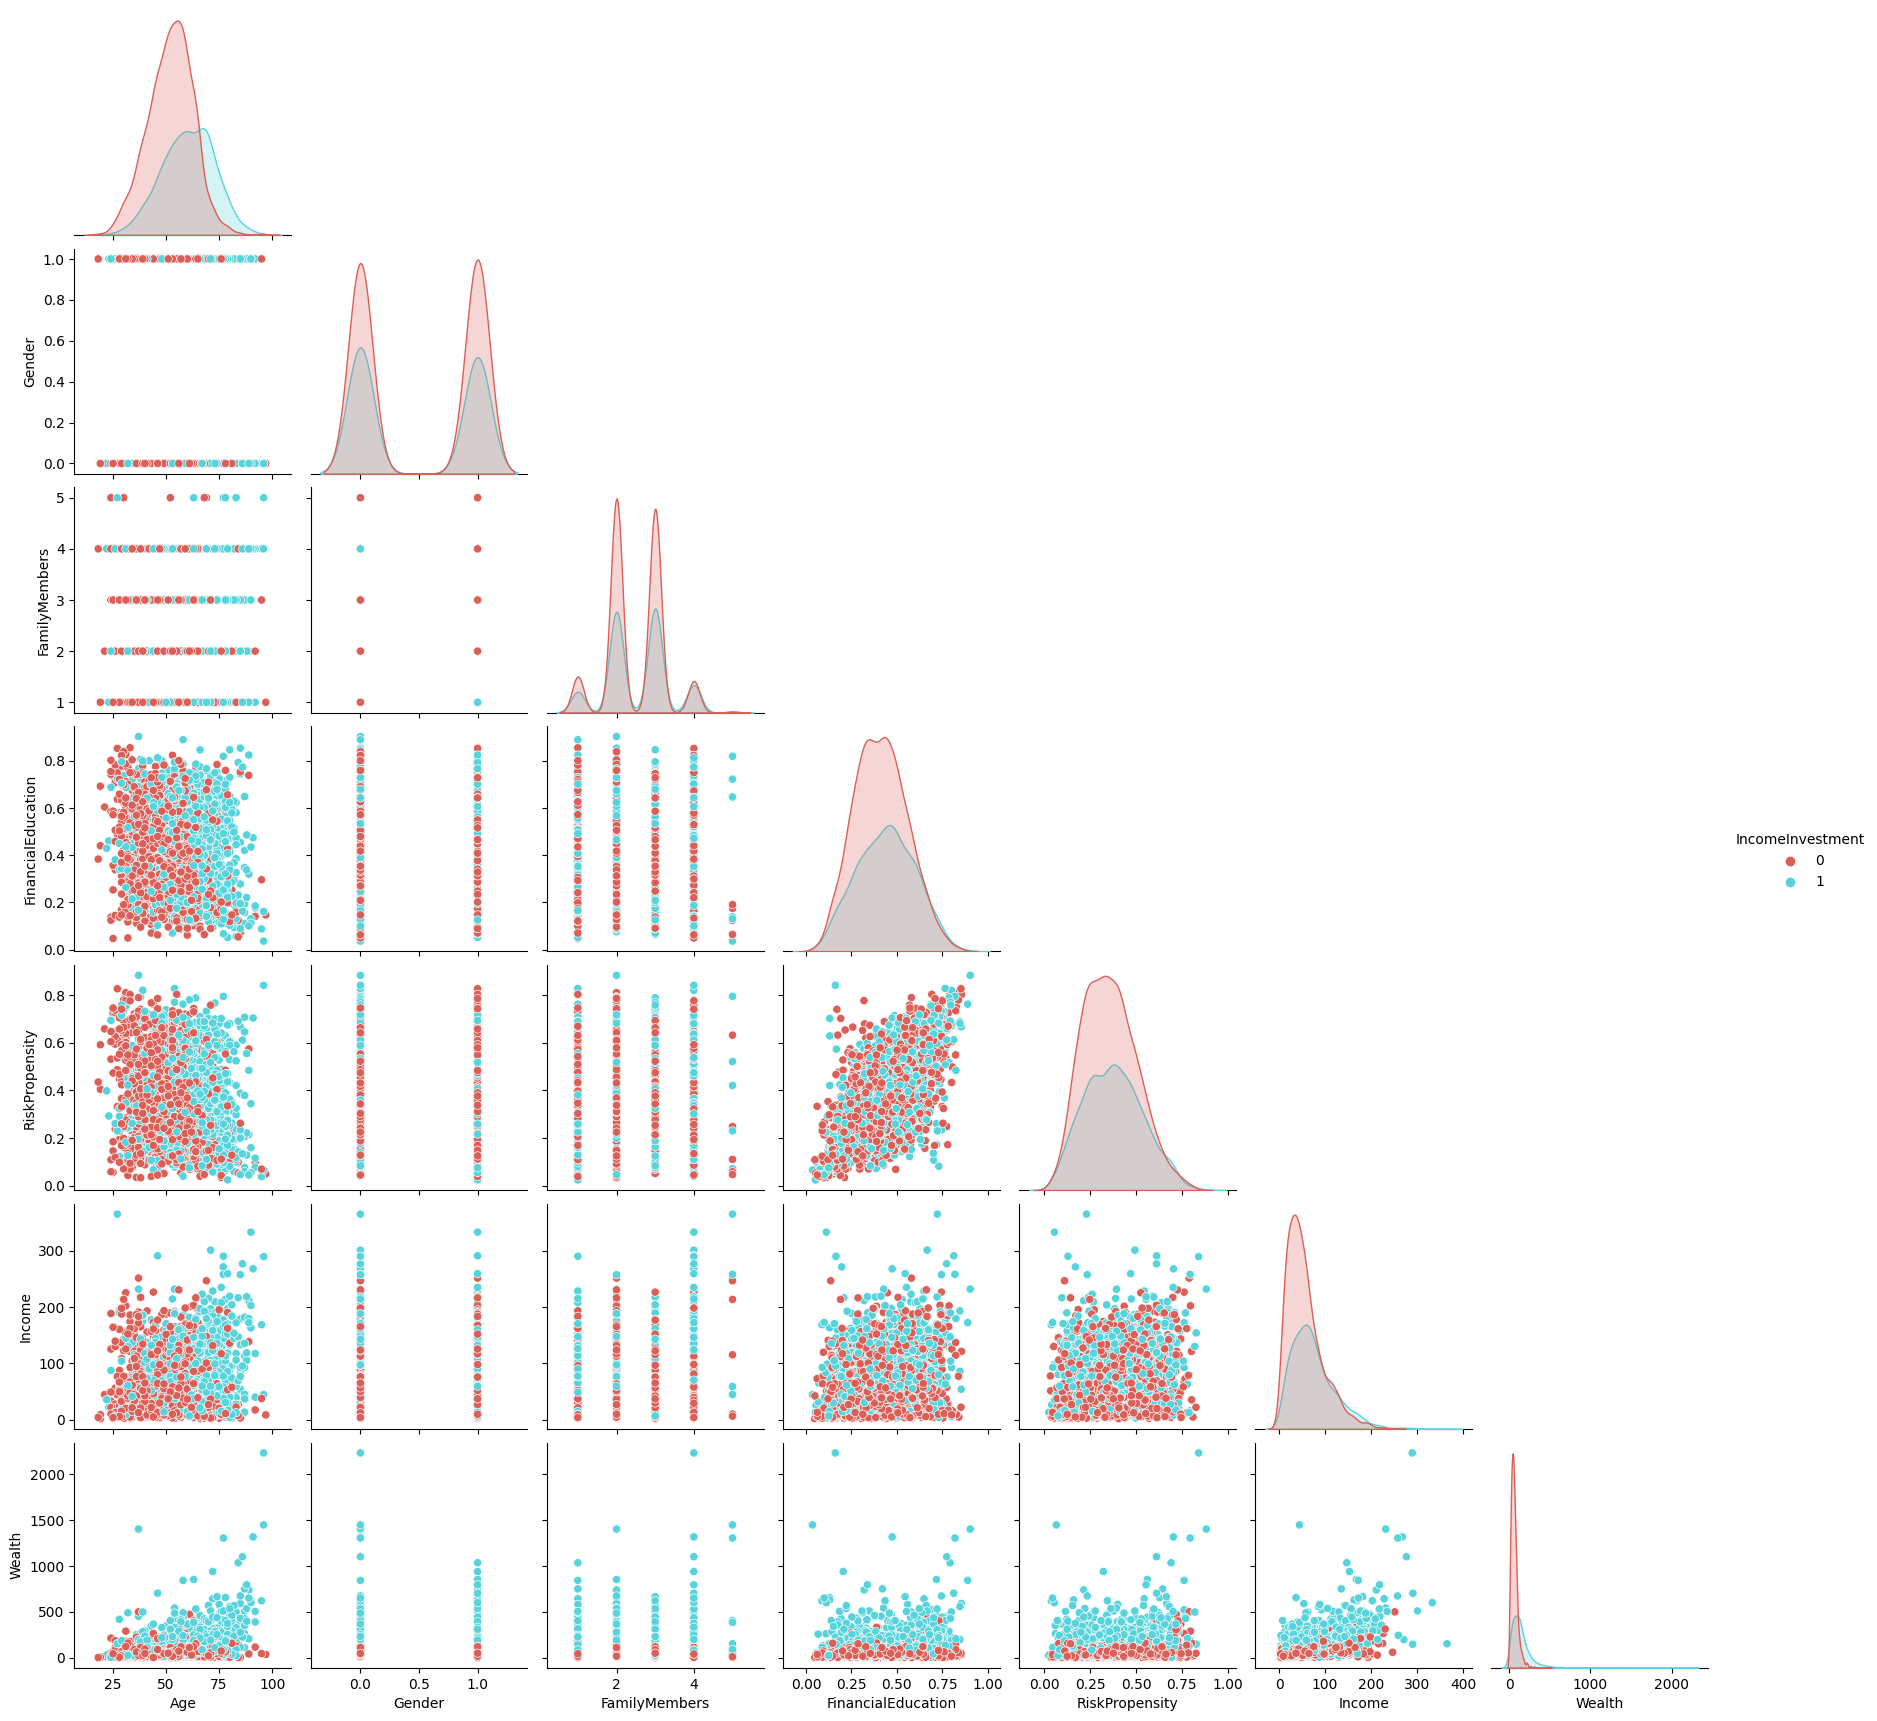

In [43]:
colour = sns.color_palette("hls", 2) # 2 is the number of possible values of IncomeInvestment feature
_ = sns.pairplot(pd.concat([x_train, y_inc_train], axis = 1), 
             hue= 'IncomeInvestment', 
             corner = True, 
             palette = colour, 
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

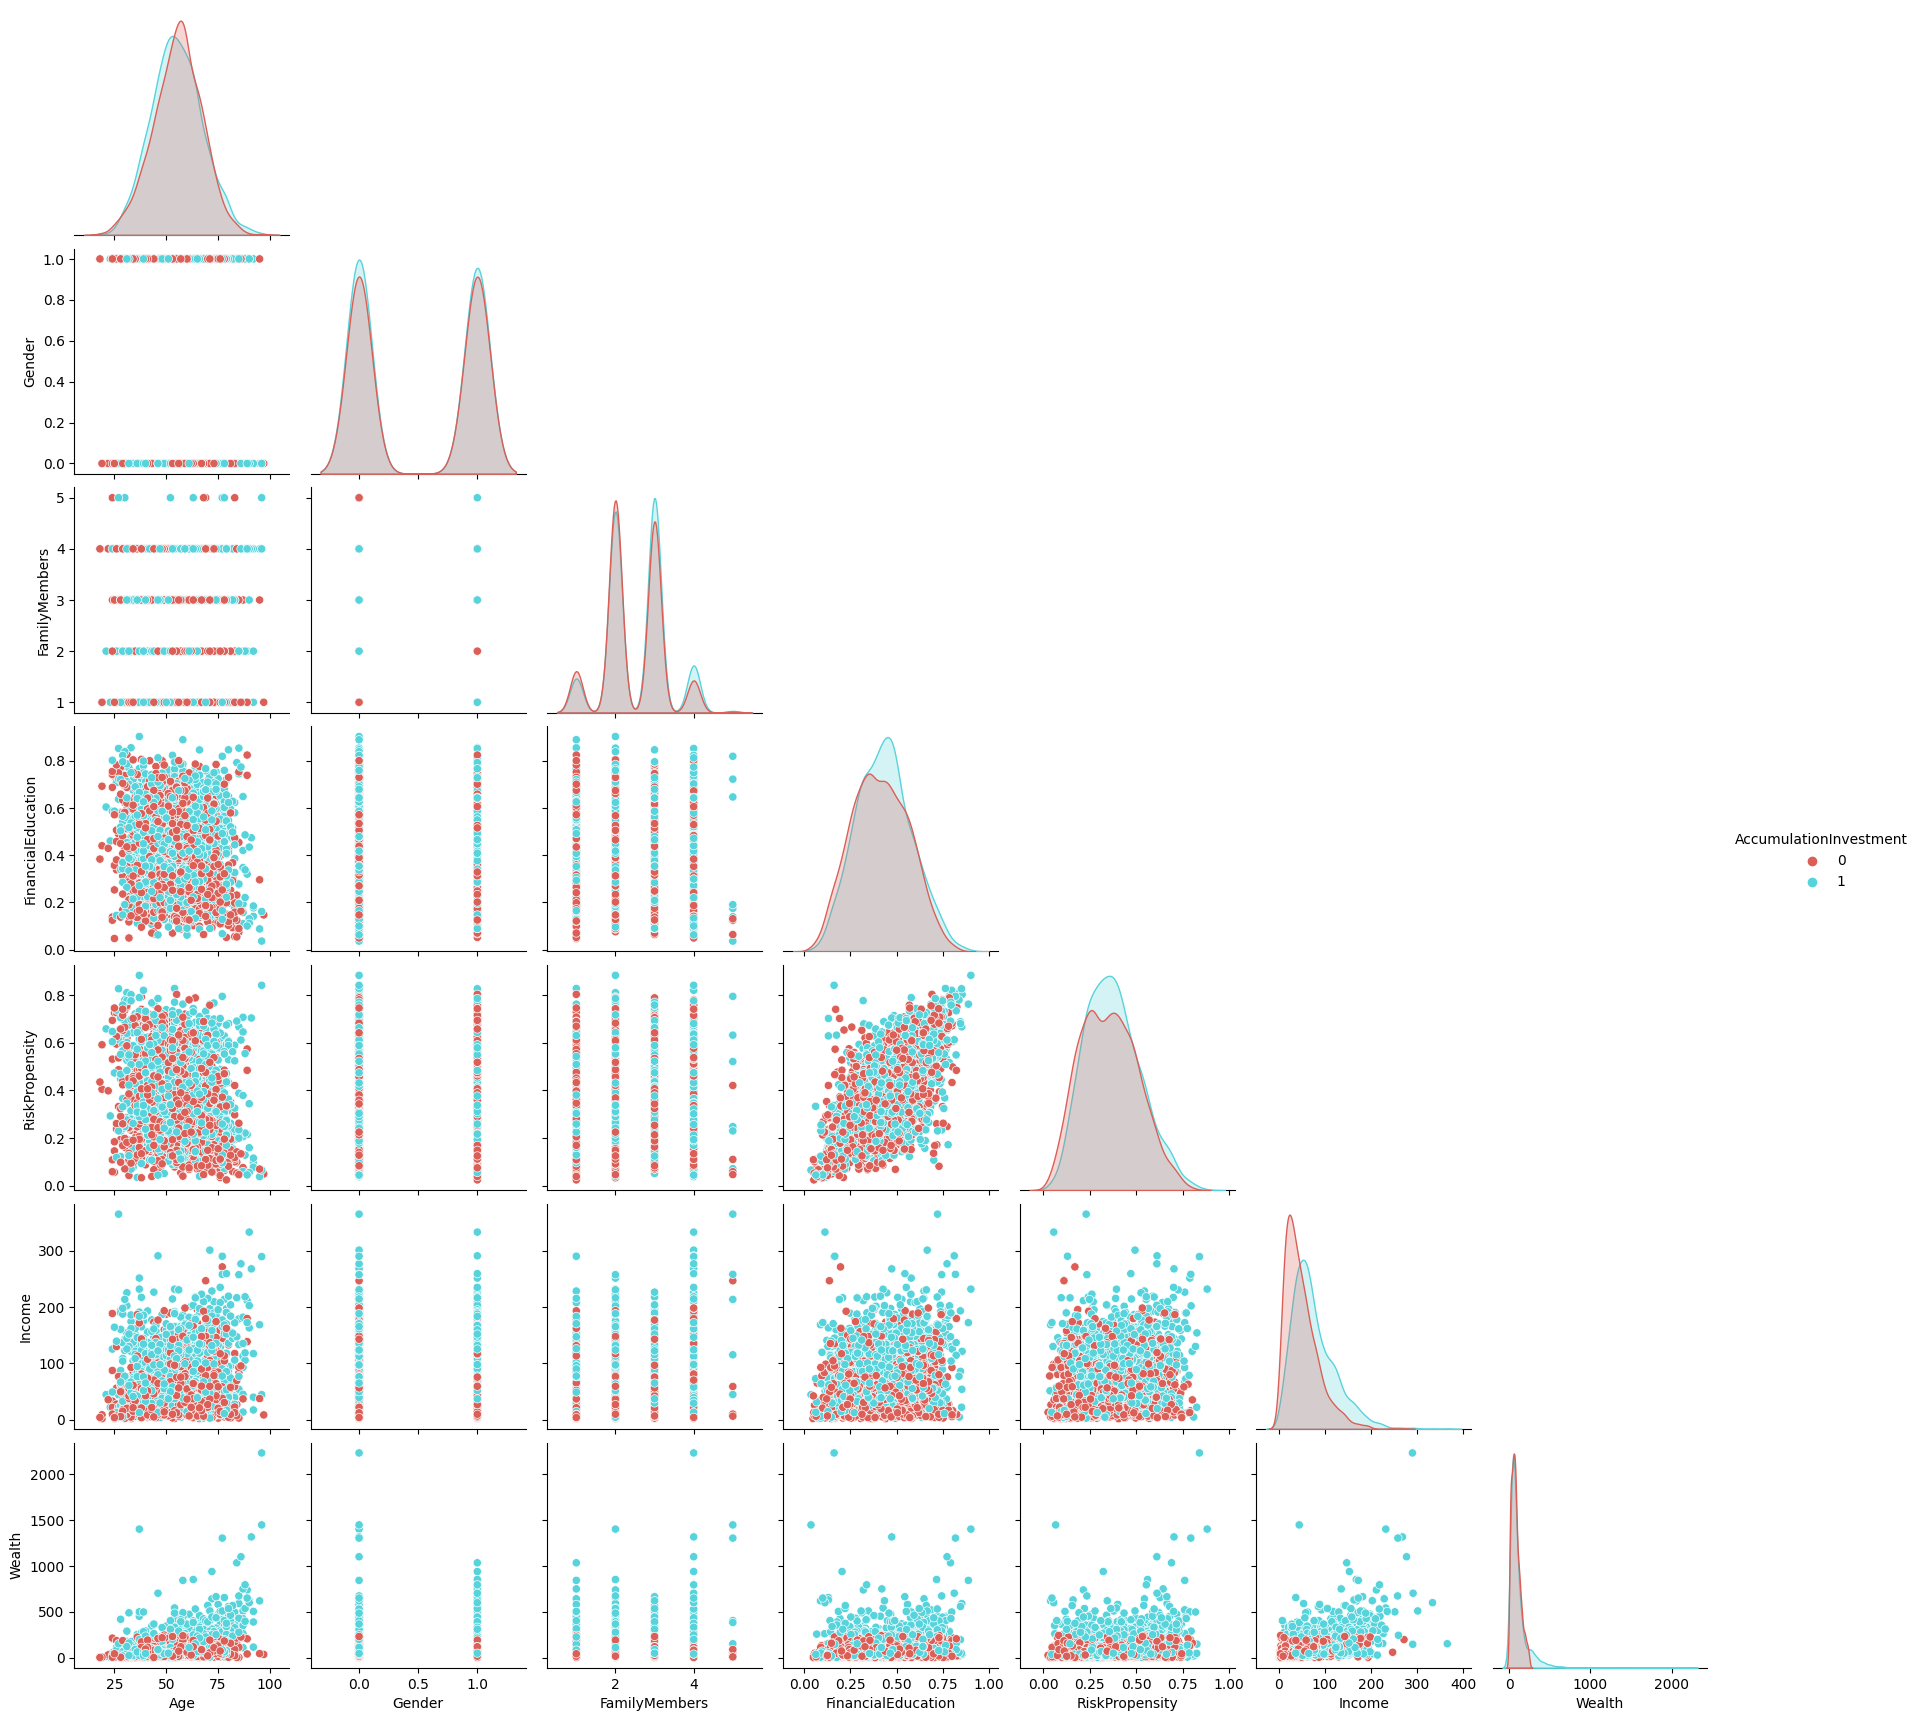

In [12]:
colour = sns.color_palette("hls", 2) # 2 is the number of possible values of AccumulationInvestment feature
_ = sns.pairplot(pd.concat([x_train, y_acc_train], axis = 1), 
             hue= 'AccumulationInvestment', 
             corner = True, 
             palette = colour, 
             vars = ['Age', 'Gender', 'FamilyMembers', 'FinancialEducation', 'RiskPropensity', 'Income', 'Wealth'])

From the multivariate plots it is possibile to notice that <code>Gender</code> feature and <code>FamilyMembers</code> features are not particularly relevant in order to establish weather a client is inclined towards accumulation investments or income investments.

# Data preprocessing

<code>Gender</code> and <code>FamilyMembers</code> features are dropped since they showed little relevance in data exploration.

In [5]:
for x in [x_train, x_test]:
    x.drop(labels='Gender', axis=1, inplace=True)
    x.drop(labels='FamilyMembers', axis=1, inplace=True)

Data exploration showed that <code>Wealth</code> and <code>Income</code> features are not gaussian distributed. A power law transformation is applied in order to modify the distribution related to these features. $0.1$ and $0.3$ values showed to work well in the two cases (transformed features are approximately gaussian distributed).

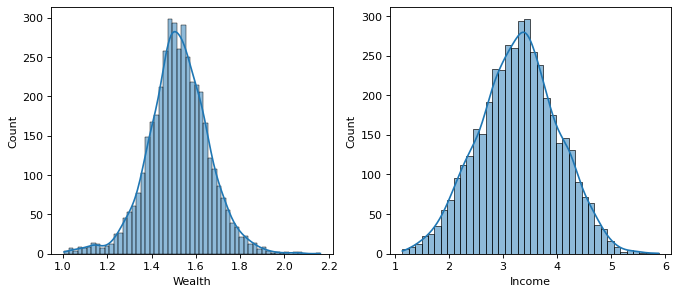

In [6]:
wealth_power = 0.1
income_power = 0.3

for x in [x_train, x_test]:
    x['Wealth'] = x['Wealth']**wealth_power
    x['Income'] = x['Income']**income_power

fig, axes = plt.subplots(1, 2, figsize=(10,4), dpi=80)
_ = sns.histplot(data=x_train, x='Wealth', ax=axes[0], kde=True)
_ = sns.histplot(data=x_train, x='Income', ax=axes[1], kde=True)

Standardization ($\mu =0\text{, }\sigma ^2=1$) is applied feature-wise to the dataframe. Mean and standard deviation values (evaluated on training set) are stored since they may be useful later to transform back to the original values.

In [7]:
features = x_train.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_train[f])
    stds[i] = np.std(x_train[f])
    for x in [x_train, x_test]:
        x[f] = (x[f] - means[i]) / stds[i]

# Classification

## Logistic regression (part 1)

Logistic regression is used as a first classification model. Two different classifiers are trained for <code>IncomeInvestment</code> and <code>AccumulationInvestment</code> targets.

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

# defining the logistic regression estimator
log_reg_inc = LogisticRegression(random_state = seed)
log_reg_acc = LogisticRegression(random_state = seed)

# fitting for income investment
_ = log_reg_inc.fit(x_train, y_inc_train)
y_inc_pred = cross_val_predict(log_reg_inc, x_train, y_inc_train, cv = 10)

# fitting for accumulation investment
_ = log_reg_acc.fit(x_train, y_acc_train)
y_acc_pred = cross_val_predict(log_reg_acc, x_train, y_acc_train, cv = 10)

### Results visualization

Confusion matrix and metrics are plotted.

Income Investment Propensity metrics:
Accuracy:	0.772
Recall:		0.582
Precision:	0.770
F1score:	0.663


Accumulation Investment Propensity metrics:
Accuracy:	0.658
Recall:		0.691
Precision:	0.659
F1score:	0.675




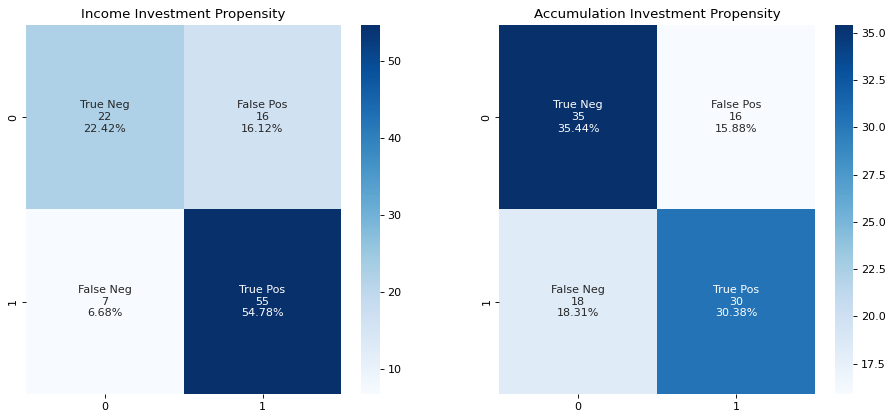

In [9]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [0, 1]):

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

<code>Commenti sui risultati ottenuti dal primo modello</code>

## Feature Engineering

Normalization and power transformation are reversed before creating <code>wealth/income</code> variable and plotting it.

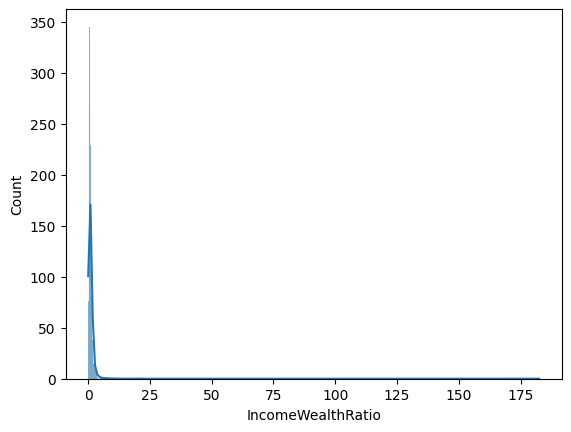

In [10]:
for f, i in zip(features, indexes):
    for x in [x_train, x_test]:
        x[f] = x[f] * stds[i] + means[i]

for x in [x_train, x_test]:
    x['Wealth'] = x['Wealth']**(1.0/wealth_power)
    x['Income'] = x['Income']**(1.0/income_power)
    x['IncomeWealthRatio'] = x['Income'] / x['Wealth']

_ = sns.histplot(data=x_train, x='IncomeWealthRatio', kde=True)

The power transformation is applied to <code>wealth/income</code> variable to modify its distribution to gaussian-like.

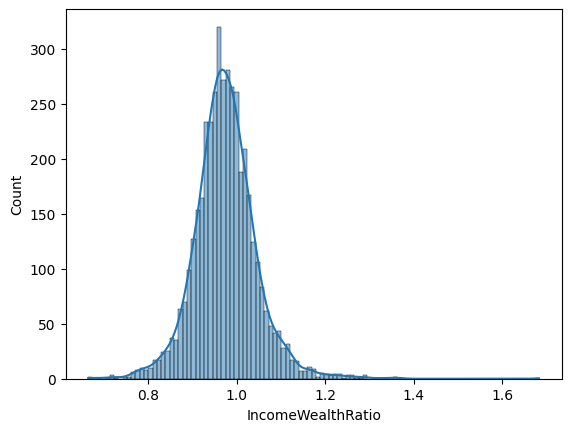

In [11]:
wealth_income_power = 0.1

for x in [x_train, x_test]:
    x['IncomeWealthRatio'] = x['IncomeWealthRatio']**wealth_income_power
    
_ = sns.histplot(data=x_train, x='IncomeWealthRatio', kde=True)

The data preprocessing already discussed above is re-applied to data in order to prepare it for classification.

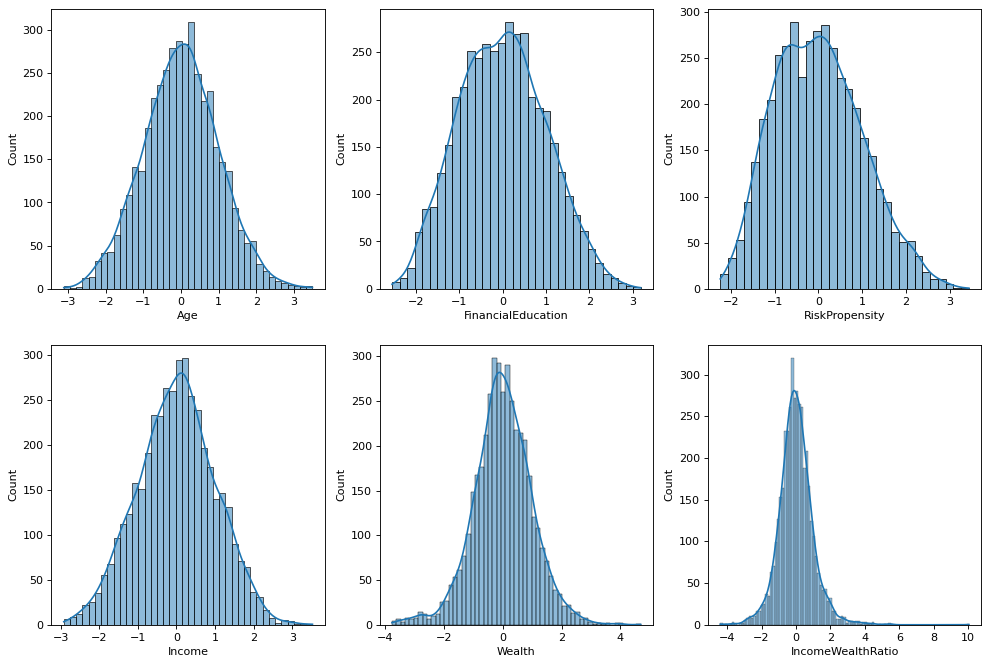

In [12]:
for x in [x_train, x_test]:
    x['Wealth'] = x['Wealth']**wealth_power
    x['Income'] = x['Income']**income_power

features = x_train.columns
indexes = np.arange(len(features))

means = np.empty(len(features))
stds = np.empty(len(features))

for f, i in zip(features, indexes):
    means[i] = np.mean(x_train[f])
    stds[i] = np.std(x_train[f])
    for x in [x_train, x_test]:
        x[f] = (x[f] - means[i]) / stds[i]

# defining the number of subplots per row and column
n_rows = 2
n_cols = 3

# creating the figure and the set of subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15,10), dpi=80)

# initializing the row and column indexes
row = column = 0

# for each feature: select the correct axis, plot the feature distribution and update the indexes
for f in features:
    ax = axes[row][column]

    sns.histplot(data=x_train, x=f, ax=ax, kde=True)

    column = column + 1
    if column % n_cols == 0:
        column = 0
        row = row + 1

## Logistic regression (part 2)

Logistic regression is fitted again on new training data.

In [13]:
# defining the logistic regression estimator
log_reg_inc = LogisticRegression(random_state = seed)
log_reg_acc = LogisticRegression(random_state = seed)

# fitting for income investment
_ = log_reg_inc.fit(x_train, y_inc_train)
y_inc_pred = cross_val_predict(log_reg_inc, x_train, y_inc_train, cv = 10)

# fitting for accumulation investment
_ = log_reg_acc.fit(x_train, y_acc_train)
y_acc_pred = cross_val_predict(log_reg_acc, x_train, y_acc_train, cv = 10)

Income Investment Propensity metrics:
Accuracy:	0.779
Recall:		0.585
Precision:	0.787
F1score:	0.671


Accumulation Investment Propensity metrics:
Accuracy:	0.657
Recall:		0.699
Precision:	0.656
F1score:	0.677




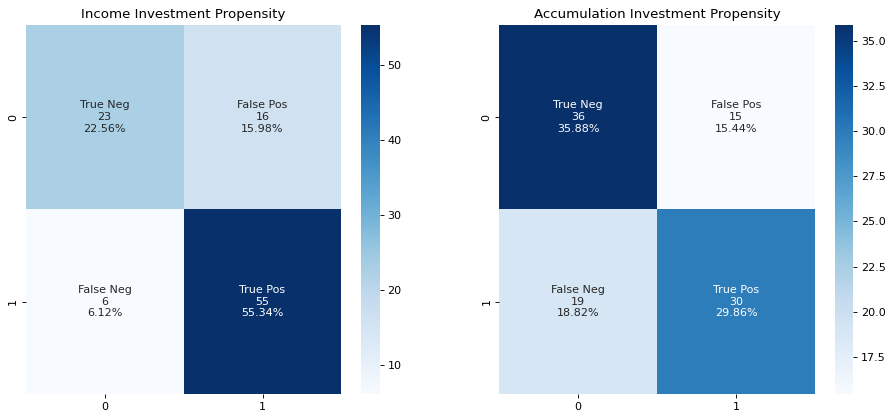

In [14]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [0, 1]):

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

This new model is not significantly better with respect to the previous one. Other techniques are tried out in order to improve classification performance.

## Random forest

<code>Insert description of the procedure here</code>

In [41]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

criterion_list = ['gini', 'entropy']
max_depth_list = [10, 12, 14]
n_estimators_list = [25, 75, 125]
min_samples_split_list = [2, 6, 10]

best_criterion = ['', '']
best_max_depth = ['', '']
best_n_estimators = ['', '']
best_min_samples_split = ['', '']

title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, i in zip([y_inc_train, y_acc_train], [0, 1]):

    f1 = 0

    for criterion in criterion_list:
        for max_depth in max_depth_list:
            for n_estimators in n_estimators_list:
                for min_samples_split in min_samples_split_list:

                    rand_forest = RandomForestClassifier(n_estimators = n_estimators,
                                                         min_samples_split = min_samples_split,
                                                         criterion = criterion, 
                                                         random_state = seed, 
                                                         max_depth = max_depth)
                    rand_forest.fit(x_train, y_train)
                    y_pred = cross_val_predict(rand_forest, x_train, y_train, cv = 10)

                    if(f1_score(y_train, y_pred) > f1):
                        best_criterion[i] = criterion
                        best_max_depth[i] = max_depth
                        best_n_estimators[i] = n_estimators
                        best_min_samples_split[i] = min_samples_split
                        f1 = f1_score(y_train, y_pred)

    print(title[i])
    print(f'Best criterion:\t{best_criterion[i]}')
    print(f'Best max_depth:\t{best_max_depth[i]}')
    print(f'Best n_estimators:\t{best_n_estimators[i]}')
    print(f'Best min_samples_split:\t{best_min_samples_split[i]}')
    print(f'F1score:\t{f1}')
    print('\n')

Income Investment Propensity
Best criterion:	entropy
Best max_depth:	14
Best n_estimators:	75
Best min_samples_split:	6
F1score:	0.7198542805100182


Accumulation Investment Propensity
Best criterion:	entropy
Best max_depth:	10
Best n_estimators:	125
Best min_samples_split:	10
F1score:	0.8212776534924187




Income Investment Propensity metrics:
Accuracy:	0.819
Recall:		0.603
Precision:	0.893
F1score:	0.720


Accumulation Investment Propensity metrics:
Accuracy:	0.831
Recall:		0.757
Precision:	0.897
F1score:	0.821




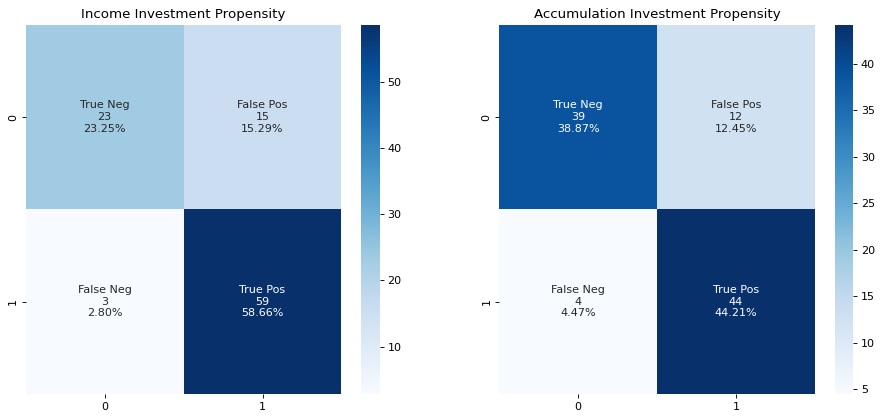

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# best_criterion = ['entropy', 'entropy']
# best_max_depth = [14, 10]
# best_n_estimators = [75, 125]
# best_min_samples_split = [6, 10]

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [0, 1]):

    rand_forest = RandomForestClassifier(n_estimators = best_n_estimators[i], 
                                         min_samples_split = best_min_samples_split[i],
                                         criterion = best_criterion[i], 
                                         random_state = seed, 
                                         max_depth = best_max_depth[i])
    rand_forest.fit(x_train, y_train)
    y_pred = cross_val_predict(rand_forest, x_train, y_train, cv = 10)

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

Results on the test set

Income Investment Propensity metrics:
Accuracy:	0.827
Recall:		0.614
Precision:	0.887
F1score:	0.726


Accumulation Investment Propensity metrics:
Accuracy:	0.831
Recall:		0.735
Precision:	0.919
F1score:	0.817




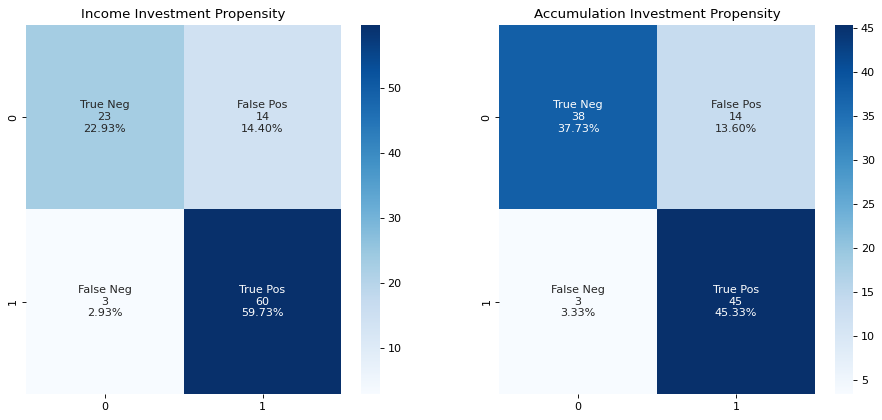

In [19]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix

# best_criterion = ['entropy', 'entropy']
# best_max_depth = [14, 10]
# best_n_estimators = [75, 125]
# best_min_samples_split = [6, 10]

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

for y_train, y_pred, y_test, i in zip([y_inc_train, y_acc_train], [y_inc_pred, y_acc_pred], [y_inc_test, y_acc_test], [0, 1]):

    rand_forest = RandomForestClassifier(n_estimators = best_n_estimators[i], 
                                         min_samples_split = best_min_samples_split[i],
                                         criterion = best_criterion[i], 
                                         random_state = seed, 
                                         max_depth = best_max_depth[i])
    rand_forest.fit(x_train, y_train)
    y_pred = rand_forest.predict(x_test)

    cf_matrix = (confusion_matrix(y_test, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_test, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_test, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_test, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_test, y_pred):.3f}')
    print('\n')

## AdaBoost

AdaBoost with decision trees.

Income Investment Propensity metrics:
Accuracy:	0.779
Recall:		0.610
Precision:	0.770
F1score:	0.681


Accumulation Investment Propensity metrics:
Accuracy:	0.783
Recall:		0.709
Precision:	0.843
F1score:	0.770




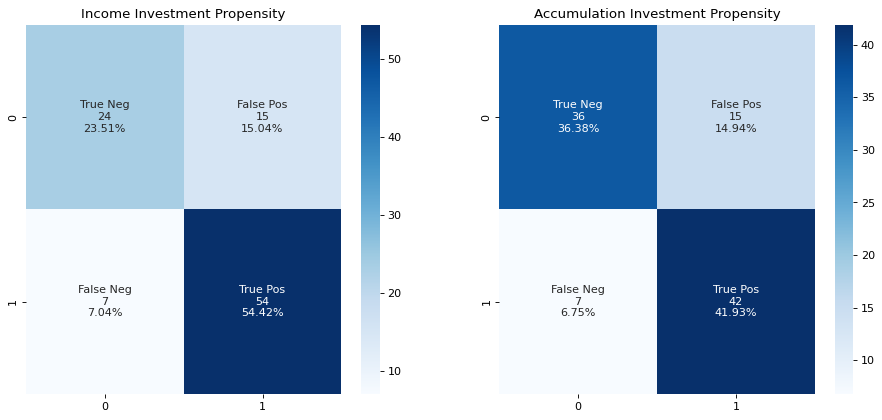

In [48]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

n_estimators = 200

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

adaboost = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = n_estimators, random_state = seed)

for y_train, i in zip([y_inc_train, y_acc_train], [0, 1]):

    adaboost.fit(x_train, y_train)
    y_pred = cross_val_predict(adaboost, x_train, y_train, cv = 10)

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

AdaBoost with perceptron.

Income Investment Propensity metrics:
Accuracy:	0.738
Recall:		0.562
Precision:	0.700
F1score:	0.623


Accumulation Investment Propensity metrics:
Accuracy:	0.579
Recall:		0.685
Precision:	0.576
F1score:	0.625




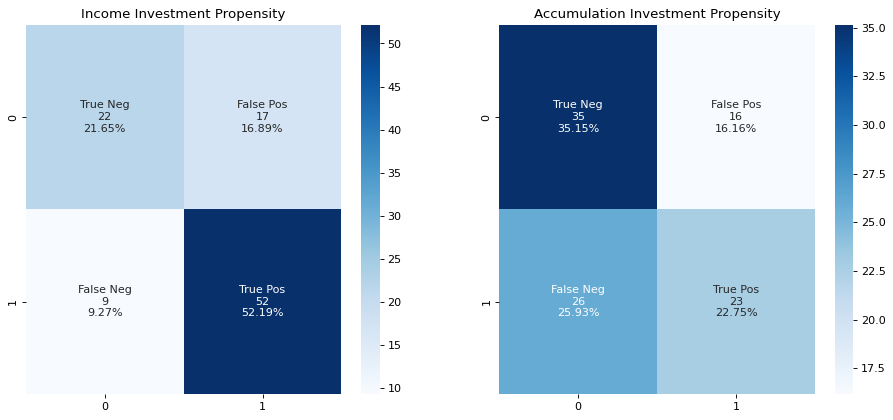

In [49]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import Perceptron

n_estimators = 200

fig, axes = plt.subplots(1, 2, figsize=(14,6), dpi=80)
title = ['Income Investment Propensity', 'Accumulation Investment Propensity']

adaboost = AdaBoostClassifier(Perceptron(random_state = seed), n_estimators = n_estimators, random_state = seed, algorithm = 'SAMME')

for y_train, i in zip([y_inc_train, y_acc_train], [0, 1]):

    adaboost.fit(x_train, y_train)
    y_pred = cross_val_predict(adaboost, x_train, y_train, cv = 10)

    cf_matrix = (confusion_matrix(y_train, y_pred, labels=[1, 0], sample_weight=None) / len(y_pred) * 100)

    group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names, group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    _ = sns.heatmap(cf_matrix, annot=labels, fmt='', ax=axes[i], cmap='Blues')
    axes[i].set_title(title[i])

    print(f'{title[i]} metrics:')
    print(f'Accuracy:\t{accuracy_score(y_train, y_pred):.3f}')
    print(f'Recall:\t\t{recall_score(y_train, y_pred):.3f}')
    print(f'Precision:\t{precision_score(y_train, y_pred):.3f}')
    print(f'F1score:\t{f1_score(y_train, y_pred):.3f}')
    print('\n')

# Recommendation system

The products list is read from the excel file.

In [33]:
products = pd.read_excel('Needs.xls', 'Products')

The products list is split between <code>income_products</code> and <code>accumulation_products</code>.

In [34]:
income_products = products[products['Type'] == 1]
accumulation_products = products[products['Type'] == 0]

The products are sorted in increasing <code>Risk</code> order.

In [35]:
income_products.sort_values('Risk', axis = 0, inplace=True)
accumulation_products.sort_values('Risk', axis = 0, inplace=True)

The minimum and maximum <code>RiskPropensity</code> values are inspected from the dataset in order to establish lower and upper bouds.

In [36]:
max_risk = np.max(df['RiskPropensity'])
min_risk = np.min(df['RiskPropensity'])
print(f'max risk = {max_risk:.3f}')
print(f'min risk = {min_risk:.3f}')

max risk = 0.883
min risk = 0.025


Adding <code>MinRisk</code> and <code>MaxRisk</code> columns to the products dataframes which will be used to assign products to clients.

In [37]:
for df in [income_products, accumulation_products]:

    lower_bound = []
    upper_bound = []

    for i in range(len(df['Risk'])):
        if (i==0):
            lower_bound.append(min_risk)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)
        elif (i==len(df['Risk'])-1):
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append(max_risk)
        else:
            lower_bound.append((df.iloc[i]['Risk'] + df.iloc[i-1]['Risk']) / 2.0)
            upper_bound.append((df.iloc[i]['Risk'] + df.iloc[i+1]['Risk']) / 2.0)

    df['MinRisk'] = lower_bound
    df['MaxRisk'] = upper_bound

Using on the risk values the same normalization used on <code>RiskPropensity</code> feature of the training set.

In [38]:
features = list(x_train.columns)
risk_index = features.index('RiskPropensity')
risk_columns = ['Risk', 'MinRisk', 'MaxRisk']

for df in [income_products, accumulation_products]:
    for r in risk_columns:
        df[r] = (df[r] - means[risk_index]) / stds[risk_index]

In [39]:
print(income_products)
print('\n')
print(accumulation_products)

    IDProduct  Type      Risk   MinRisk   MaxRisk
8           9     1 -0.621428 -2.247205 -0.323072
5           6     1 -0.024716 -0.323072  0.141037
4           5     1  0.306791  0.141037  0.538845
7           8     1  0.770900  0.538845  1.002955
0           1     1  1.235010  1.002955  1.898023
6           7     1  2.561037  1.898023  2.991996
10         11     1  3.422955  2.991996  3.440918


   IDProduct  Type      Risk   MinRisk   MaxRisk
2          3     0 -1.615949 -2.247205 -1.582798
9         10     0 -1.549647 -1.582798 -0.986086
1          2     0 -0.422524 -0.986086  0.041585
3          4     0  0.505695  0.041585  3.440918


Defining the two classifiers for <code>income investment propensity</code> and <code>accumulation investment propensity</code>.

In [43]:
income_classifier = RandomForestClassifier(n_estimators = best_n_estimators[0], 
                                           min_samples_split = best_min_samples_split[0],
                                           criterion = best_criterion[0], 
                                           random_state = seed, 
                                           max_depth = best_max_depth[0])
_ = income_classifier.fit(x_train, y_inc_train)

accumulation_classifier = RandomForestClassifier(n_estimators = best_n_estimators[1], 
                                                 min_samples_split = best_min_samples_split[1],
                                                 criterion = best_criterion[1], 
                                                 random_state = seed, 
                                                 max_depth = best_max_depth[1])
_ = accumulation_classifier.fit(x_train, y_acc_train)

The function that assigns the best product to a client given the classifiers and the products dataframes is defined.

In [44]:
def assign_product(client, income_classifier, accumulation_classifier, income_products, accumulation_products):

    # with [:,1] I pick the probability of the client to have the prediction = 1
    inc_pred = income_classifier.predict_proba(client)[:,1]
    acc_pred = accumulation_classifier.predict_proba(client)[:,1]
    client_risk = client.iloc[0]['RiskPropensity']
    
    # if inc_pred > acc_pred then the client is more inclined towards income investments -> income product
    if (inc_pred >= acc_pred):
        for i in range(len(income_products['IDProduct'])):
            if (client_risk >= income_products.iloc[i]['MinRisk'] and client_risk <= income_products.iloc[i]['MaxRisk']):
                return income_products.iloc[i]['IDProduct']
    else:
        for i in range(len(accumulation_products['IDProduct'])):
            if (client_risk >= accumulation_products.iloc[i]['MinRisk'] and client_risk <= accumulation_products.iloc[i]['MaxRisk']):
                return accumulation_products.iloc[i]['IDProduct']

Defining the product dictionary

In [45]:
products = {1.0: 'Balanced Mutual Fund',
            2.0: 'Income Conservative Unit-Linked (Life Insurance)',
            3.0: 'Fixed Income Mutual Fund',
            4.0: 'Balanced High Dividend Mutual Fund',
            5.0: 'Balanced Mutual Fund',
            6.0: 'Defensive Flexible Allocation Unit-Linked (Life Insurance)',
            7.0: 'Aggressive Flexible Allocation Unit-Linked (Life Insurance)',
            8.0: 'Balanced Flexible Allocation Unit-Linkled (Life Insurance)',
            9.0: 'Cautious Allocation Segregated Account',
            10.0: 'Fixed Income Segregated Account',
            11.0: 'Total Return Aggressive Allocation Segregated Account'}

Trying to assign a product to the first client of the dataframe.

In [47]:
example_product = products[assign_product(client = x_train.head(1), 
                                  income_classifier = income_classifier,
                                  accumulation_classifier = accumulation_classifier,
                                  income_products = income_products,
                                  accumulation_products = accumulation_products)]

print(f'Product assigned to first client: {example_product}')

Product assigned to first client: Income Conservative Unit-Linked (Life Insurance)
